In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import zipfile
from PIL import Image, ImageStat
import io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import random

2024-05-30 21:05:51.052537: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 21:05:51.492194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 21:05:52.945540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:


batch_size = 32
img_height = 180
img_width = 180

def image_quality(image):
    gray = image.convert("L")
    stat = ImageStat.Stat(gray)
    return stat.stddev[0]


            

def apply_clahe(image, clip_limit,tile_grid_size):
    img_np = np.array(image)
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return Image.fromarray(img_clahe_rgb)

import concurrent.futures
from scipy.optimize import differential_evolution
def optimize_params(image):
    def objective(params):
        clip_limit, tile_grid_size = params
        try:
            img_clahe = apply_clahe(image, clip_limit, int(tile_grid_size))
            return -image_quality(img_clahe)
        except cv2.error:
            print("CV2 error")
            return np.inf
    bounds = [(2,5), (2,8)]
    result = differential_evolution(objective, bounds, strategy = 'best1bin', maxiter = 5, popsize=5, tol=0.01)
    return result.x

def apply_clahe_split(image, clip_limit,tile_grid_size):
    red,green,blue = image.split()
    # redM = ( 1,   0,  0, 0, 
    #        0,   0,  0, 0, 
    #        0,     0, 0, 0) 
    # greenM = ( 0,   0,  0, 0, 
    #        0,   0,  1, 0, 
    #        0,     0, 0, 0) 
    # blueM = ( 0,   0,  0, 0, 
    #        0,   0,  0, 0, 
    #        0,     0, 1, 0) 
    # red.convert("RGB").convert("RGB",redM).save("./example/redBefore.png")
    # green.convert("RGB").convert("RGB",greenM).save("./example/greenBefore.png")
    # blue.convert("RGB").convert("RGB",blueM).save("./example/blueBefore.png")
    redImage = apply_clahe(red.convert("RGB"), clip_limit,tile_grid_size)
    greenImage = apply_clahe(green.convert("RGB"), clip_limit,tile_grid_size)
    blueImage = apply_clahe(blue.convert("RGB"), clip_limit,tile_grid_size)
    # redImage.convert("RGB",redM).save("./example/redAfter.png")
    # greenImage.convert("RGB",greenM).save("./example/greenAfter.png")
    # blueImage.convert("RGB",blueM).save("./example/blueAfter.png")
    outputImage = Image.merge("RGB",(redImage.convert("L"),greenImage.convert("L"),blueImage.convert("L") ) )
    return outputImage
    
def apply_clahe_numpy(img_np,  clip_limit, tile_grid_size):
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR    
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return img_clahe_rgb

def apply_clahe_optimized(image,i):
    clip_limit, tile_grid_size = optimize_params(image)
    if(i % 10 == 0):
        print("Params CLIP: " + str(clip_limit) + " - TILE: " +  str(tile_grid_size) )
    return apply_clahe(image, clip_limit, tile_grid_size)

In [3]:
# baseImg = PIL.Image.open("./low-quality-cropped/fake/29.png")
# imgFinal = apply_clahe_split(baseImg,3,15)
# imgFinal.save("./example/finalAfter.png")

In [4]:
face_cascade = cv2.CascadeClassifier("face_detectorzz.xml")
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [9]:
def apply_clahe_directory(inputDir, outputDir):
    names = glob(inputDir+ "/*.*")
    for name in names:
        fileName = name.split("/")[-1]
        image = PIL.Image.open(name)
        clahe = apply_clahe(image,3,15)
        clahe.save(outputDir + "/" + fileName[:-4] + ".png")
apply_clahe_directory("./low-quality-filtered/fake", "./low-quality-clahe/fake")
apply_clahe_directory("./low-quality-filtered/real", "./low-quality-clahe/real")

In [18]:
def apply_crop(inputDir, outputDir):
    names = glob(inputDir+ "/*.jpg")
    for name in names:
        fileName = name.split("/")[-1]
        image = cv2.imread(name)
        #print(image)
        #faces = face_cascade.detectMultiScale(image, 1.1, 4)
        faces = face_classifier.detectMultiScale(
        image, scaleFactor=1.1, minNeighbors=5, minSize=(90, 90)
        )
        maxH = 0
        maxW = 0
        x,y,w,h = (-1,-1,-1,-1)
        for (x_, y_, w_, h_) in faces:
            if(w_ * h_) > (w * h):
                x = x_
                y = y_
                w = w_
                h = h_
        if h == -1:
            continue
        if h != -1:
            yMin = max(y-10,0)
            xMin = max(x-10,0)
            image = image[yMin:y+h+10, xMin:x+w+10]
        imgrgb = image[:, :, ::-1]  # Convert BGR to RGB
        image = Image.fromarray(imgrgb)
        #cv2.imwrite(outputDir + "/" + fileName,image)
        image.save(outputDir + "/" + fileName[:-4] + ".png")
        imageInit = PIL.Image.open(name)
        imageInit.save("./low-quality-filtered/" + outputDir[-4:] + "/" + fileName[:-4] + ".png")
apply_crop("./low-quality/fake", "./low-quality-cropped/fake")
apply_crop("./low-quality/real", "./low-quality-cropped/real")

In [78]:
def apply_clahe_split_directory(inputDir, outputDir):
    names = glob(inputDir+ "/*.*")
    for name in names:
        fileName = name.split("/")[-1]
        image = PIL.Image.open(name)
        clahe = apply_clahe_split(image,3,15)
        clahe.save(outputDir + "/" + fileName[:-4] + ".png")
apply_clahe_split_directory("./low-quality-filtered/fake", "./low-quality-split/fake")
apply_clahe_split_directory("./low-quality-filtered/real", "./low-quality-split/real")

In [19]:
def apply_clahe_splitc_directory(inputDir, outputDir):
    names = glob(inputDir+ "/*.*")
    for name in names:
        fileName = name.split("/")[-1]
        image = PIL.Image.open(name)
        clahe = apply_clahe_split(image,3,12)
        clahe.save(outputDir + "/" + fileName[:-4] + ".png")
apply_clahe_splitc_directory("./low-quality-cropped/fake", "./low-quality-split-cropped/fake")
apply_clahe_splitc_directory("./low-quality-cropped/real", "./low-quality-split-cropped/real")

In [60]:
def apply_clahe_optimized_directory(inputDir, outputDir):
    names = glob(inputDir+ "/*.jpg")
    i = 0
    for name in names:
        i += 1
        if(i % 10 == 0):
            print("Round " + str(i))
        fileName = name.split("/")[-1]
        image = PIL.Image.open(name)
        clahe = apply_clahe_optimized(image,i)
        clahe.save(outputDir + "/" + fileName[:-4] + ".png")
apply_clahe_optimized_directory("./low-quality/fake", "./low-quality-opt/fake")
apply_clahe_optimized_directory("./low-quality/real", "./low-quality-opt/real")

Round 10
Params CLIP: 4.996992721122265 - TILE: 2.5950901646743834
Round 20
Params CLIP: 4.989106125878057 - TILE: 2.5586599460517663
Round 30
Params CLIP: 4.895643683692425 - TILE: 2.8203876147595555
Round 40
Params CLIP: 3.9996379486573166 - TILE: 3.0702789165990243
Round 50
Params CLIP: 4.989585684790023 - TILE: 2.396987829259603
Round 60
Params CLIP: 4.976207864115679 - TILE: 2.838795204144401
Round 70
Params CLIP: 2.0440506687450775 - TILE: 2.5866285640087936
Round 80
Params CLIP: 4.995444531967966 - TILE: 2.569237222960333
Round 90
Params CLIP: 4.927267556346186 - TILE: 2.4958971212487726
Round 100
Params CLIP: 4.9646471370693614 - TILE: 2.310913648982967
Round 110
Params CLIP: 4.978088211015011 - TILE: 2.9099783639430106
Round 120
Params CLIP: 4.930285423374024 - TILE: 2.247175295613371
Round 130
Params CLIP: 4.998505412467583 - TILE: 2.249744674645428
Round 140
Params CLIP: 4.516608171293349 - TILE: 2.799057000968285
Round 150
Params CLIP: 4.777980011419138 - TILE: 2.8651085161

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

def get_model(num_classes = 2):
    # input_shape = (global_image_dim, global_image_dim, 3)  
    # model = build_model(input_shape)
    # return model
    
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(180,
                                      180,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )
    model = Sequential([
          data_augmentation,
          layers.Rescaling(1./255),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(128, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dense(256, activation='relu'),
          layers.Dense(num_classes, name="outputs")
        ])
    # model = Sequential([
    #       data_augmentation,
    #       layers.Rescaling(1./255),
    #       layers.Conv2D(64, 3, padding='same', activation='relu'),
    #       layers.MaxPooling2D(),
    #       layers.Conv2D(128, 3, padding='same', activation='relu'),
    #       layers.MaxPooling2D(),
    #       layers.Conv2D(128, 3, padding='same', activation='relu'),
    #       layers.MaxPooling2D(),
    #       #layers.Dropout(0.2),
    #       layers.Flatten(),
    #       layers.Dense(128, activation='relu'),
    #       layers.Dense(num_classes, name="outputs")
    #     ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    # input_shape = (global_image_dim, global_image_dim, 3)  
    # model = build_model(input_shape)
    return model






In [7]:
def get_datasets(data_dir):
    batch_size = 32
    img_height = 180
    img_width = 180
    train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.20,
      subset="training",
      seed=123,
      image_size=(180,180),
      batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.20,
      subset="validation",
      seed=123,
      image_size=(180,180),
      batch_size=batch_size)

    return train_ds, val_ds


def evaluate(directory):
    train_ds, val_ds = get_datasets(directory)
    model = get_model()
    epochs = 40
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    return (val_acc, val_loss)



Found 1587 files belonging to 2 classes.
Using 1270 files for training.
Found 1587 files belonging to 2 classes.
Using 317 files for validation.
Epoch 1/40


2024-05-30 21:31:11.505746: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.5071 - loss: 1.1864 - val_accuracy: 0.4984 - val_loss: 0.6926
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5154 - loss: 0.6918 - val_accuracy: 0.5016 - val_loss: 0.6930
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.4946 - loss: 0.6931 - val_accuracy: 0.4984 - val_loss: 0.6920
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5156 - loss: 0.6900 - val_accuracy: 0.5016 - val_loss: 0.6930
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.4987 - loss: 0.6920 - val_accuracy: 0.5016 - val_loss: 0.6910
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5489 - loss: 0.6876 - val_accuracy: 0.5615 - val_loss: 0.6822
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.5749 - loss: 0.6763 - val_accuracy: 0.6215 - val_loss: 0.6691
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6322 - loss: 0.6648 - val_accuracy: 0.7571 - val_loss: 0.

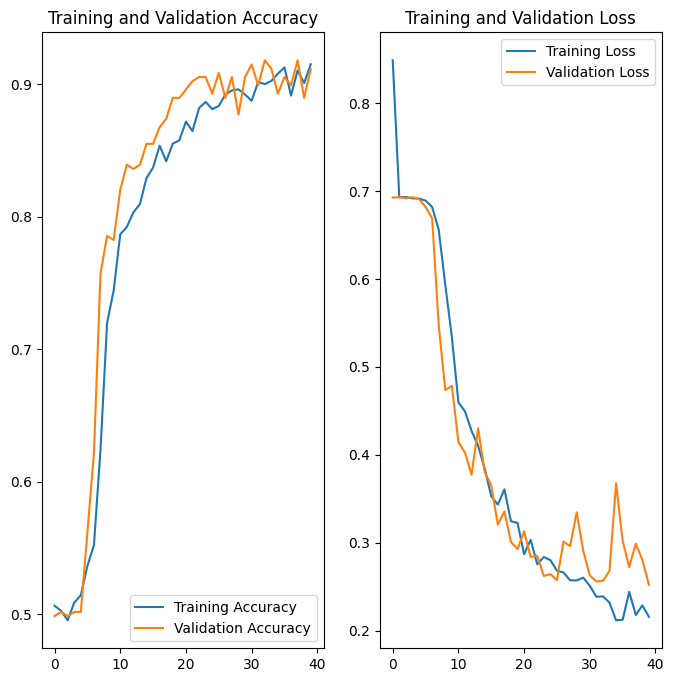

In [15]:
clahe_acc, clahe_loss = evaluate("low-quality-clahe")

In [14]:
#raw_acc, raw_loss = evaluate("low-quality-filtered")

In [13]:
#evaluate("low-quality-split")

In [11]:
#evaluate("low-quality-opt")

Found 1587 files belonging to 2 classes.
Using 1270 files for training.
Found 1587 files belonging to 2 classes.
Using 317 files for validation.
Epoch 1/40


2024-05-30 21:33:23.251203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4759 - loss: 0.9377 - val_accuracy: 0.4984 - val_loss: 0.6922
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5203 - loss: 0.6907 - val_accuracy: 0.5016 - val_loss: 0.6892
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5618 - loss: 0.6789 - val_accuracy: 0.5489 - val_loss: 0.6879
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7102 - loss: 0.5767 - val_accuracy: 0.8423 - val_loss: 0.3527
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8148 - loss: 0.4427 - val_accuracy: 0.8297 - val_loss: 0.4023
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8307 - loss: 0.3884 - val_accuracy: 0.8391 - val_loss: 0.3583
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8321 - loss: 0.3674 - val_accuracy: 0.8580 - val_loss: 0.3421
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8460 - loss: 0.3616 - val_accuracy: 0.8517 - val_loss: 0.

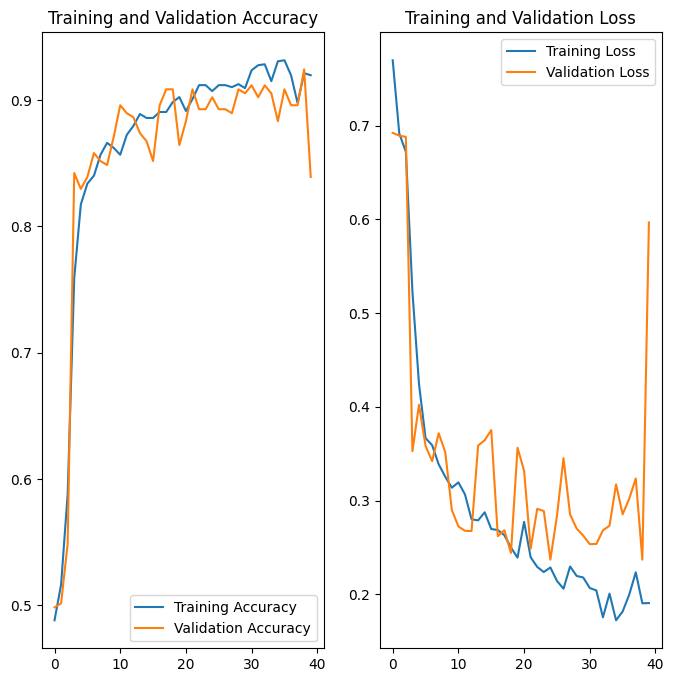

In [16]:
split_c_acc, split_c_loss = evaluate("low-quality-split-cropped")

In [12]:
#evaluate("low-quality-cropped")

In [61]:
clahe_accs = []
clahe_losses = []
splitc_accs = []
splitc_losses = []

In [4]:
clahe_accs = list(np.load("np_clahe_accs.npy"))
clahe_losses =list(np.load("np_clahe_losses.npy"))
splitc_accs = list(np.load("np_splitc_accs.npy"))
splitc_losses = list(np.load("np_splitc_losses.npy"))

In [131]:
np_clahe_accs = np.array(clahe_accs)
np_clahe_losses = np.array(clahe_losses)
np_splitc_accs = np.array(splitc_accs)
np_splitc_losses = np.array(splitc_losses)

np.save("np_clahe_accs.npy",np_clahe_accs)
np.save("np_clahe_losses.npy",np_clahe_losses)
np.save("np_splitc_accs.npy",np_splitc_accs)
np.save("np_splitc_losses.npy",np_splitc_losses)


In [17]:
from copy import deepcopy

clahe_accs.append(deepcopy(clahe_acc))
clahe_losses.append(deepcopy(clahe_loss))
splitc_accs.append(deepcopy(split_c_acc))
splitc_losses.append(deepcopy(split_c_loss))

In [18]:
import heapq
print("Standard CLAHE")
claheAverageAcc = 0
claheAccs = []
for accs in clahe_accs:
    x = sum(heapq.nlargest(5,accs)) / 5
    claheAccs.append(x)
    claheAverageAcc += sum(heapq.nlargest(5,accs)) / 5
claheAverageAcc /= len(clahe_accs)

claheAverageLoss = 0
claheLosses = []
for losses in clahe_losses:
    x = sum(heapq.nsmallest(5,losses)) / 5
    claheLosses.append(x)
    claheAverageLoss += sum(heapq.nsmallest(5,losses)) / 5
claheAverageLoss /= len(clahe_losses)
print("Average Accuracy: " + str(claheAverageAcc))
print("Average Loss: " + str(claheAverageLoss))
print("Lower Bound: Accuracy: " + str( np.percentile(np.array(claheAccs),5)))
print("Upper Bound: Accuracy: "+ str( np.percentile(np.array(claheAccs),95)))
print("Lower Bound: Loss: " + str( np.percentile(np.array(claheLosses),5)))
print("Upper Bound: Loss: "+ str( np.percentile(np.array(claheLosses),95)))

print("-----------------------")
print("Split CLAHE and Cropped")
splitAverageAcc = 0
splitAccs = []
for accs in splitc_accs:
    x = sum(heapq.nlargest(5,accs)) / 5
    splitAccs.append(x)
    splitAverageAcc += sum(heapq.nlargest(5,accs)) / 5
splitAverageAcc /= len(splitc_accs)

splitAverageLoss = 0
splitLosses = []
for losses in splitc_losses:
    x = sum(heapq.nsmallest(5,losses)) / 5
    splitLosses.append(x)
    splitAverageLoss += sum(heapq.nsmallest(5,losses)) / 5
splitAverageLoss /= len(splitc_losses)
print("Average Accuracy: " + str(splitAverageAcc))
print("Average Loss: " + str(splitAverageLoss))
print("Lower Bound: Accuracy: " + str( np.percentile(np.array(splitAccs),5)))
print("Upper Bound: Accuracy: "+ str( np.percentile(np.array(splitAccs),95)))
print("Lower Bound: Loss: " + str( np.percentile(np.array(splitLosses),5)))
print("Upper Bound: Loss: "+ str( np.percentile(np.array(splitLosses),95)))

Standard CLAHE
Average Accuracy: 0.9050473272800446
Average Loss: 0.26680012270808223
Lower Bound: Accuracy: 0.8917981088161469
Upper Bound: Accuracy: 0.9152366071939468
Lower Bound: Loss: 0.24640923202037812
Upper Bound: Loss: 0.29165242820978166
-----------------------
Split CLAHE and Cropped
Average Accuracy: 0.9101735129952431
Average Loss: 0.25250432044267657
Lower Bound: Accuracy: 0.895173504948616
Upper Bound: Accuracy: 0.9190220981836319
Lower Bound: Loss: 0.239763692766428
Upper Bound: Loss: 0.2681812143325806


In [21]:
def calc_percentiles(lis):
    count = len(lis[0])
    lowP = []
    highP = []
    for i in range(count):
        curL = []
        for j in range(1,len(lis)):
            curL.append(lis[j][i])
        npL = np.array(curL)
        lowP.append(np.percentile(npL,5))
        highP.append(np.percentile(npL,95))
    return highP, lowP

mergedClaheAcc = np.array(clahe_accs[0])
for i in range(1,len(clahe_accs)):
    mergedClaheAcc += np.array(clahe_accs[i])
mergedClaheAcc /= len(clahe_accs)

mergedClaheAccHigh, mergedClaheAccLow = calc_percentiles(clahe_accs)
mergedClaheLossHigh, mergedClaheLossLow = calc_percentiles(clahe_losses)

mergedClaheLoss = np.array(clahe_losses[0])
for i in range(1,len(clahe_losses)):
    mergedClaheLoss += np.array(clahe_losses[i])
mergedClaheLoss /= len(clahe_losses)

splitcAcc = np.array(splitc_accs[0])
for i in range(1,len(splitc_accs)):
    splitcAcc += np.array(splitc_accs[i])
splitcAcc /= len(splitc_accs)

splitcAccHigh, splitcAccLow = calc_percentiles(splitc_accs)
splitcLossHigh, splitcLossLow = calc_percentiles(splitc_losses)

splitcLoss = np.array(splitc_losses[0])
for i in range(1,len(splitc_losses)):
    splitcLoss += np.array(splitc_losses[i])
splitcLoss /= len(splitc_losses)

Text(0.5, 1.0, 'Standard vs New Accuracy')

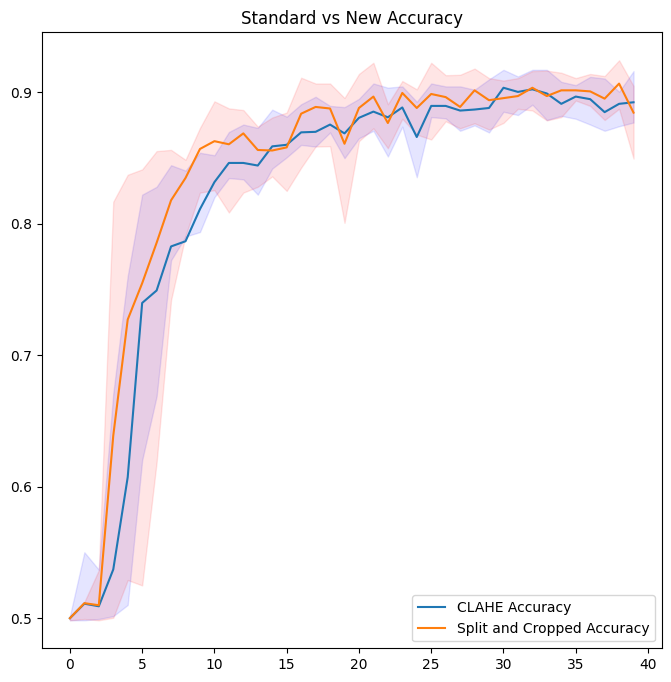

In [20]:
epochs_range = range(len(clahe_accs[0]))
plt.figure(figsize=(8, 8))
#plt.plot(epochs_range, mergedClaheAcc, label='CLAHE Accuracy')
# plt.plot(epochs_range, mergedClaheAccLow, label='CLAHE Accuracy Low')
plt.fill_between(epochs_range, mergedClaheAccLow, mergedClaheAccHigh, color='b', alpha=.1)
plt.fill_between(epochs_range, splitcAccLow, splitcAccHigh, color='r', alpha=.1)
plt.plot(epochs_range, mergedClaheAcc, label='CLAHE Accuracy')
plt.plot(epochs_range, splitcAcc, label='Split and Cropped Accuracy')
plt.legend(loc='lower right')
plt.title('Standard vs New Accuracy')

Text(0.5, 1.0, 'Standard vs New Loss')

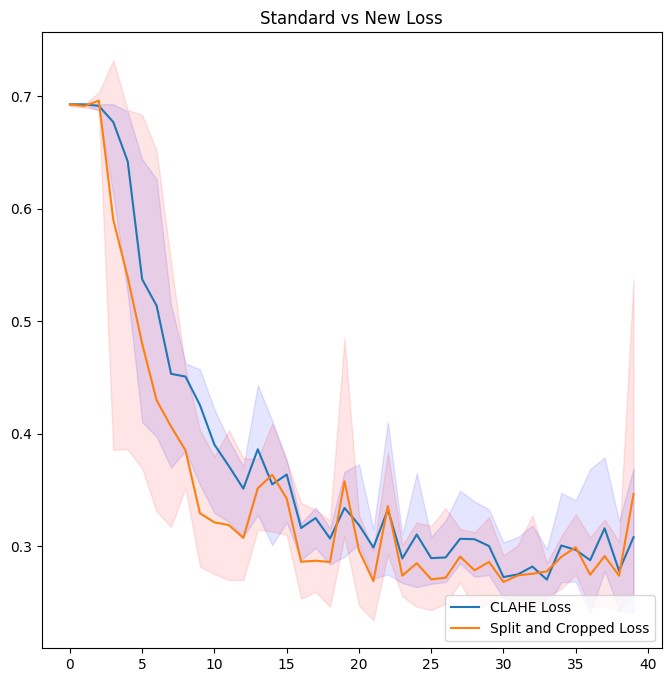

In [22]:
epochs_range = range(len(clahe_accs[0]))
plt.figure(figsize=(8, 8))
plt.fill_between(epochs_range, mergedClaheLossLow, mergedClaheLossHigh, color='b', alpha=.1)
plt.fill_between(epochs_range, splitcLossLow, splitcLossHigh, color='r', alpha=.1)
plt.plot(epochs_range, mergedClaheLoss, label='CLAHE Loss')
plt.plot(epochs_range, splitcLoss, label='Split and Cropped Loss')
plt.legend(loc='lower right')
plt.title('Standard vs New Loss')

In [27]:
import pandas as pd
data = {
    'Model': ['Standard CLAHE', 'Split CLAHE'],
    'Accuracy Lower Bound' : [np.percentile(np.array(claheAccs),5),np.percentile(np.array(splitAccs),5)],
    'Accuracy': [claheAverageAcc,splitAverageAcc ],  
    'Accuracy Upper Bound' : [np.percentile(np.array(claheAccs),95),np.percentile(np.array(splitAccs),95)],
    'Loss Lower Bound' : [np.percentile(np.array(claheLosses),5),np.percentile(np.array(splitLosses),5)],
    'Loss': [claheAverageLoss,splitAverageLoss] ,      
    'Loss Upper Bound' : [np.percentile(np.array(claheLosses),95),np.percentile(np.array(splitLosses),95)],
}

df = pd.DataFrame(data)
df

,Model,Accuracy Lower Bound,Accuracy,Accuracy Upper Bound,Loss Lower Bound,Loss,Loss Upper Bound
0,Standard CLAHE,0.891798,0.905047,0.915237,0.246409,0.266800,0.291652
1,Split CLAHE,0.895174,0.910174,0.919022,0.239764,0.252504,0.268181


In [30]:
from scipy import stats
t, p = stats.ttest_rel(claheAccs, splitAccs)
print('CLAHE vs. Split t = ', str(t), ' p = ', str(p))

CLAHE vs. Split t =  -1.1200477190258529  p =  0.29964598645165513
